In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import skill_metrics as sm
import torch
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader

from src.dataset import GoncaDataset
from src.model import MLP, AutoEncoder, FinalModule

seaborn.set()
torch.manual_seed(32)
np.random.seed(32)

HORIZONS = 12
WINDOW = 3
FORWARD_EXPANSION = 1
N_LAYERS = 1
DECOMP_METHOD = 'fft'
DEVICE = torch.device('cuda')

In [2]:
def plot_taylor(refs: dict, predictions_dict: dict):

    models = list(predictions_dict.keys())
    colors = ['c', 'm', 'y', 'k', 'r', 'b', 'g']
    colors = colors[:len(models)]
    models = {model: color for model, color in zip(models, colors)}
    for idx, (model, pred_dict) in enumerate(predictions_dict.items()):
        taylor_stats = []
        name = model[0]
        for horizon, pred in pred_dict.items():
            taylor_stats.append(sm.taylor_statistics(pred, refs[name][int(horizon)], 'data'))

        sdev = np.array([taylor_stats[0]['sdev'][0]]+[x['sdev'][1]
                                                    for x in taylor_stats])
        crmsd = np.array([taylor_stats[0]['crmsd'][0]]+[x['crmsd'][1]
                                                        for x in taylor_stats])
        ccoef = np.array([taylor_stats[0]['ccoef'][0]]+[x['ccoef'][1]
                                                        for x in taylor_stats])

        # To change other params in the plot, check SkillMetrics documentation in
        # https://github.com/PeterRochford/SkillMetrics/wiki/Target-Diagram-Options
        if len(list(predictions_dict.keys())) != 1:
            if idx != len(list(predictions_dict.keys()))-1 or len(list(predictions_dict.keys())) == 1:
                sm.taylor_diagram(sdev, crmsd, ccoef, styleOBS='-',
                                colOBS='g', markerobs='o',
                                markercolor=models[model])
            else:
                sm.taylor_diagram(sdev, crmsd, ccoef, styleOBS='-',
                                titleOBS='Observation',
                                colOBS='g', markerobs='o', markercolor=models[model],
                                overlay = 'on', markerLabel=models)
        else:
            sm.taylor_diagram(sdev, crmsd, ccoef, styleOBS='-',
                      colOBS='g', markerobs='o',
                      titleOBS='Observation', markercolor='c',
                      markerLabel=['placeholder']+[
                          k+1 for k, v in pred_dict.items()])

In [3]:
dataset = GoncaDataset(window=WINDOW,
                           horizons=HORIZONS,
                           data_name='Australia2',
                           decomp_method=DECOMP_METHOD,
                           decomp=True)

train_loader = DataLoader(dataset, batch_size=128,
                            shuffle=True, num_workers=8)

input_example = next(iter(train_loader))[0]
input_size = input_example.shape[1]*input_example.shape[2]

/home/mateus/miniconda3/envs/ts/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
Decomp serie in 7 components
Getting test components


In [4]:
auto_encoder = AutoEncoder(input_size=input_size,
                               horizons=HORIZONS, device=DEVICE,
                               forward_expansion=FORWARD_EXPANSION,
                               num_layers=N_LAYERS)

trainer = Trainer(gpus=1, max_epochs=5)
trainer.fit(auto_encoder, train_dataloader=train_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mateus/miniconda3/envs/ts/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 813 K 
1 | decoder | Decoder | 1.1 M 
------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
Epoch 4: 100%|██████████| 548/548 [00:12<00:00, 44.92it/s, loss=0.00348, v_num=4, train_loss_step=0.00465, train_loss_epoch=0.00482]


1

In [5]:
final_model = FinalModule(input_size=input_size,
                              horizons=HORIZONS, device=DEVICE,
                              forward_expansion=FORWARD_EXPANSION,
                              num_layers=N_LAYERS)
final_model.load_encoder(auto_encoder.encoder)
final_trainer = Trainer(gpus=1, max_epochs=5)
final_trainer.fit(final_model, train_dataloader=train_loader)


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 813 K 
1 | fc_out  | Linear  | 6.2 K 
------------------------------------
6.2 K     Trainable params
813 K     Non-trainable params
819 K     Total params
Epoch 4: 100%|██████████| 548/548 [00:07<00:00, 77.70it/s, loss=0.00473, v_num=5, train_loss_step=0.00423, train_loss_epoch=0.00422]


1

In [6]:
mlp = MLP(input_size=input_size, horizons=HORIZONS)
mlp_trainer = Trainer(gpus=1, max_epochs=5)
mlp_trainer.fit(mlp, train_dataloader=train_loader)


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 174   
--------------------------------------
174       Trainable params
0         Non-trainable params
174       Total params
Epoch 4: 100%|██████████| 548/548 [00:06<00:00, 79.04it/s, loss=0.00262, v_num=6, train_loss_step=0.00223, train_loss_epoch=0.00268]


1

In [7]:
dataset.set_type('test')
mlp = mlp.cpu()
final_model = final_model.cpu()
X_test = dataset.samples
y = dataset.labels
y_final = final_model(X_test).detach().numpy()/dataset.test_scaler.scale_
y_mlp = mlp(X_test).detach().numpy()/dataset.test_scaler.scale_
preds = {}
preds['Transformer'] = {i: y_final[:, i] for i in range(HORIZONS)}
preds['MLP'] = {i: y_mlp[:, i] for i in range(HORIZONS)}
refs = {key: {i: y[:, i].numpy()/dataset.test_scaler.scale_ for i in range(HORIZONS)} for key in ['T', 'M']}

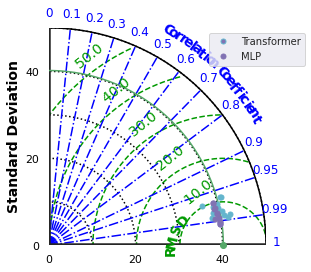

In [8]:
plot_taylor(refs, preds)
plt.show()

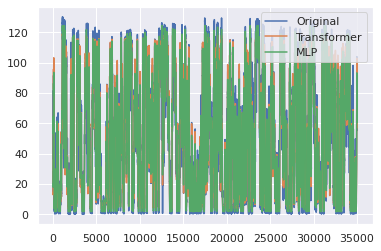

In [9]:
plt.plot(y[:, 0].numpy()/dataset.test_scaler.scale_)
plt.plot(y_final[:, 0])
plt.plot(y_mlp[:, 0])
plt.legend(['Original', 'Transformer', 'MLP'])
plt.show()